In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
soccfg = soc
print(soccfg)

QICK running on RFSoC4x2, software version 0.2.340

Firmware configuration (built Wed Sep  6 18:49:29 2023):

	Global clocks (MHz): tProc dispatcher timing 409.600, RF reference 491.520
	Groups of related clocks: [tProc clock, DAC tile 0], [DAC tile 2], [ADC tile 0]

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 Msps, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 Msps, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 Msps, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		axis_avg_buffer v1.0 (no edge counter, no weights)
		memory 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PY

In [62]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        max_env_value=32766
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)

        
        
        #configure the readout lengths and downconversion frequencies
        self.declare_readout(ch=cfg["ro_ch"], length=self.cfg["readout_length"],
                             freq=self.cfg["pulse_freq"],phase=0, gen_ch=cfg["res_ch"])

        freq=self.freq2reg(cfg["pulse_freq"], gen_ch=cfg["res_ch"], ro_ch=cfg["ro_ch"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        
        rampup_length=self.us2cycles(cfg["rampup_time"],gen_ch=cfg["res_ch"])*16 # convert rampup time to the generator's fabric clock length, *16 is because one clock has 16 data loaded 
        rampup_data=np.linspace(0,max_env_value,rampup_length)
        
        # Set waveform
        self.add_envelope(ch=cfg["res_ch"], name = "ramping_up", idata=rampup_data)
        # self.add_gauss(ch=cfg["res_ch"], name="qubit", sigma=cfg["sigma"], length=cfg["sigma"]*4)
        
        self.add_envelope(ch=cfg["res_ch"], name = "const", idata=max_env_value*np.ones(16*3))
        self.add_envelope(ch=cfg["res_ch"], name = "zeros", idata=np.zeros(16*3))
        
        self.default_pulse_registers(ch=cfg["res_ch"], style="arb", freq=freq, phase=cfg["res_phase"], gain=cfg["pulse_gain"])
        self.set_pulse_registers(ch=cfg["res_ch"],waveform="ramping_up")

        self.synci(200)  # give processor some time to configure pulses
        pass
    
    def body(self):
        self.trigger(adcs=[self.cfg["ro_ch"]],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        self.pulse(ch=self.cfg["res_ch"]) # play ramping up pulse
        
        self.set_pulse_registers(ch=self.cfg["res_ch"],waveform="const",mode="periodic") # play constant pulse
        self.pulse(ch=self.cfg["res_ch"]) 
        self.set_pulse_registers(ch=self.cfg["res_ch"],waveform="zeros",mode="oneshot") # play stop pulse
#         self.pulse(ch=self.cfg["res_ch"],t=self.us2cycles(self.cfg["const_time"]+self.cfg["rampup_time"]))

        self.wait_all() 

        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels

In [66]:
config={"res_ch":1, # --generator channel number
        "ro_ch":1, # --readout channel number
        "reps":1, # --body repetition times
        "relax_delay":1.0, # --Fixed
        "res_phase":0, # --DAC phase        
        "readout_length":300, # [readout fabric Clock ticks]
        "pulse_gain":40000, # [DAC units]
        "pulse_freq": 187*2, # [MHz]
        "adc_trig_offset": 100, # [tproc Clock ticks]
        "soft_avgs":1,
        "reps":1,
        ### pulse variables
        "rampup_time":0.1, # unit us
        "const_time": 1e6# unit us
       }

prog =LoopbackProgram(soccfg, config)
print(prog)
(iq0,) = prog.acquire_decimated(soc, progress=True)
# (iq0,) = prog.acquire_decimated(soc, progress=True,start_src="external") # use this to start the program with external trigger in PMOD1_0


// Program

        regwi 1, $22, 163403091;                //freq = 163403091
        regwi 1, $23, 0;                        //phase = 0
        regwi 1, $25, 40000;                    //gain = 40000
        regwi 1, $24, 0;                        //addr = 0
        regwi 1, $26, 524349;                   //phrst| stdysel | mode | | outsel = 0b01000 | length = 61 
        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: regwi 0, $16, 32768;                    //out = 0b1000000000000000
        seti 7, 0, $16, 100;                    //ch =0 out = $16 @t = 0
        seti 7, 0, $0, 110;                     //ch =0 out = 0 @t = 0
        regwi 1, $27, 0;                        //t = 0
        set 1, 1, $22, $23, $24, $25, $26, $27; //ch = 1, pulse @t = $27
        regwi 1, $24, 61;                       //addr = 61
        regwi 1, $26, 786435;                   //phrst| stdysel | mode | | outsel = 0b01100 | length = 3 
        regwi 1, $27, 40;                     

  0%|          | 0/1 [00:00<?, ?it/s]

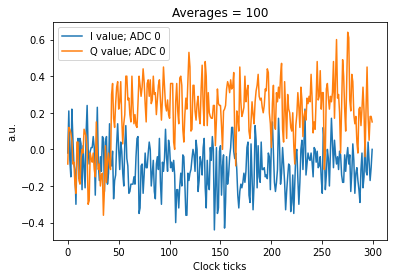

In [10]:
# Plot results.
plt.figure(1)
plt.plot(iq0[0], label="I value; ADC 0")
plt.plot(iq0[1], label="Q value; ADC 0")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Conditional_False_Pulse.pdf", dpi=350)

In [51]:
prog.soccfg['gens'][1]

{'type': 'axis_signal_gen_v6',
 'fullpath': 'axis_signal_gen_v6_1',
 'revision': 4,
 'version': '1.0',
 'tproc_ch': 1,
 'dac': '20',
 'has_mixer': False,
 'fs': 9830.4,
 'fs_mult': 20,
 'fs_div': 1,
 'interpolation': 1,
 'f_fabric': 614.4,
 'f_dds': 9830.4,
 'fdds_div': 1,
 'maxlen': 65536,
 'b_dds': 32,
 'b_phase': 32,
 'switch_ch': 1,
 'samps_per_clk': 16,
 'maxv': 32766,
 'maxv_scale': 1.0}

In [93]:
32830/16

2051.875

In [172]:
np.linspace(0,100,16*100)

array([0.00000000e+00, 6.25390869e-02, 1.25078174e-01, ...,
       9.98749218e+01, 9.99374609e+01, 1.00000000e+02])

In [163]:
prog.us2cycles(prog.cycles2us(50),ro_ch=1)

68

In [165]:
prog.us2cycles(0.2,ro_ch=1)

111

In [342]:
?AveragerProgram

Init signature: AveragerProgram(soccfg, cfg)
Docstring:     
AveragerProgram class is an abstract base class for programs which do loops over experiments in hardware.
It consists of a template program which takes care of the loop and acquire methods that talk to the processor to stream single shot data in real-time and then reshape and average it appropriately.

:param soccfg: This can be either a QickSoc object (if the program is running on the QICK) or a QickCOnfig (if running remotely).
:type soccfg: QickConfig
:param cfg: Configuration dictionary
:type cfg: dict
Init docstring:
Constructor for the AveragerProgram, calls make program at the end.
For classes that inherit from this, if you want it to do something before the program is made and compiled:
either do it before calling this __init__ or put it in the initialize method.
File:           /home/xilinx/jupyter_notebooks/qick/qick_lib/qick/averager_program.py
Type:           ABCMeta
Subclasses:     LoopbackProgram, LoopbackProgra

In [201]:
asm_v1.QickRegister(prog,0,1)

In [57]:
prog_test = QickProgram(soccfg)

In [60]:
?prog_test.load_prog

Signature: prog_test.load_prog(progdict)
Docstring: Load the program from a dictionary.
File:      /home/xilinx/jupyter_notebooks/qick/qick_lib/qick/qick_asm.py
Type:      method


In [5]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.4.0
ipykernel        : 6.15.1
ipywidgets       : 7.7.1
jupyter_client   : 7.3.4
jupyter_core     : 4.11.1
jupyter_server   : 1.18.1
jupyterlab       : 3.4.4
nbclient         : 0.5.13
nbconvert        : 6.5.0
nbformat         : 5.4.0
notebook         : 6.4.12
qtconsole        : 5.3.1
traitlets        : 5.3.0


In [24]:
result = soc.tproc.single_read(addr=123)
print("Result = ", result)

Result =  0
